In [213]:
# adapted from https://pyro.ai/examples/prodlda.html
# imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import torch
import time

import math
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange

# Importing modules
import re
from typing import Pattern

#plotting libraries!
import matplotlib.pyplot as plt
%matplotlib inline

# Import the wordcloud library
from wordcloud import WordCloud

from sklearn.metrics.pairwise import cosine_similarity

**Apply to movie set**  
**end goal:**  
want to  map/group movies (doc id) to topics so we can look up a topic and find related movies or vice versa  
**what we have:**  
movie descriptions for ~9k movies from netflix titles database  
**conversion:**  
- our LDA model takes in a matrix of token counts and outputs beta values
- need to convert what we have into a matrix of token counts using the CountVectorizer function
    - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [214]:
# import user rating data
movies_df = pd.read_csv("./movies.csv")
ratings_df = pd.read_csv("./ratings.csv")

# import data and create relevant dfs
netflix_df = pd.read_csv("./netflix_titles.csv")
# df = pd.read_csv("./titles_sample.csv")
netflix_df['description'] = netflix_df['description'].map(lambda x: re.sub("([^\x00-\x7F])+","", x)) # from jessica's code

In [215]:
# slice years off of titles, remove any quotations
def modify_title(str):
    pattern = r" [(]\d*[)]"
    new_str = re.sub(pattern, '', str)
    new_str = new_str.replace('"', '')
    # move 'The' to beginning of title
    if new_str[-5:] == ", The":
        new_str = "The " + new_str
        new_str = new_str[:-5]
    return new_str

movies_df['title'] = movies_df['title'].apply(modify_title)

In [216]:
# join titles with netflix db movie titles
eval_df = netflix_df.merge(movies_df, on='title', how='left')
# drop titles in netflix that aren't in movielens
eval_df = eval_df.dropna(subset=['movieId'])
# drop irrelvant columns
eval_df.drop(columns=['show_id', 'type', 'director', 'cast', 'country', 'date_added', 
                    'release_year', 'duration', 'rating', 'listed_in', 'genres'], inplace=True)
eval_df = eval_df.reset_index()
print(len(eval_df))
eval_df

1119


,index,title,description,movieId
0,27,Grown Ups,Mourning the loss of their beloved junior high...,79134.0
1,28,Dark Skies,A familys idyllic suburban life shatters when ...,100810.0
2,41,Jaws,When an insatiable great white shark terrorize...,1387.0
3,42,Jaws 2,Four years after the last deadly shark attacks...,1388.0
4,44,Jaws: The Revenge,"After another deadly shark attack, Ellen Brody...",4124.0
...,...,...,...,...
1114,8853,"Yours, Mine and Ours",When a father of eight and a mother of 10 prep...,40962.0
1115,8862,Zodiac,"A political cartoonist, a crime reporter and a...",51540.0
1116,8864,Zombieland,Looking to survive in a world taken over by zo...,71535.0
1117,8865,Zoom,"Dragged from civilian life, a former superhero...",47384.0


In [217]:
data = eval_df['description'].to_numpy() 
# `max_df` removes common words - words with frequency higher than this across all documents
# `min_df` removes rare words - words that appear in less than min_df number of docs
# note: if min_df is too big, will get error in word cloud (i think because not enough data for all topics)
# max min_df i've found that works is 5
vectorizer = CountVectorizer(min_df=5, max_df=0.7, stop_words='english') # 1, 0.7
# docs is a binary matrix of size M x N where M is number of movies, N is number of words in vocab
# docs[i, j] is 1 if movie i's descriptoin has word j and 0 otherwise
docs = torch.from_numpy(vectorizer.fit_transform(data).toarray())

# creates df with words and indices corresponding to words 
# used to convert betas back to words in word cloud plots
vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names()
vocab['index'] = vocab.index

print('Dictionary size: %d' % len(vocab))
print('Corpus size: {}'.format(docs.shape))

Dictionary size: 695
Corpus size: torch.Size([1119, 695])


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [218]:
# setting global variables related to LDA computation
smoke_test=False
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_topics = 15 if not smoke_test else 3
docs = docs.float().to(device)
batch_size = 32
learning_rate = 1e-3
num_epochs = 50 if not smoke_test else 1

In [219]:
class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # for the effect of this flag in BatchNorm1d
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale


class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)


class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)

    def model(self, docs):
        pyro.module("decoder", self.decoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param = self.decoder(theta)
            # Currently, PyTorch Multinomial requires `total_count` to be homogeneous.
            # Because the numbers of words across documents can vary,
            # we will use the maximum count accross documents here.
            # This does not affect the result because Multinomial.log_prob does
            # not require `total_count` to evaluate the log probability.
            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs',
                dist.Multinomial(total_count, count_param),
                obs=docs
            )

    def guide(self, docs):
        pyro.module("encoder", self.encoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.cpu().detach().T

In [220]:
# training 
pyro.clear_param_store()

prodLDA = ProdLDA(
    vocab_size=docs.shape[1],
    num_topics=num_topics,
    hidden=100 if not smoke_test else 10,
    dropout=0.2
)
prodLDA.to(device)

optimizer = pyro.optim.Adam({"lr": learning_rate})
svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(docs.shape[0] / batch_size)) if not smoke_test else 1

start = time.perf_counter()
bar = trange(num_epochs)
for epoch in bar:
    running_loss = 0.0
    for i in range(num_batches):
        batch_docs = docs[i * batch_size:(i + 1) * batch_size, :]
        loss = svi.step(batch_docs)
        running_loss += loss / batch_docs.size(0)

    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))
end = time.perf_counter()
print(f"Finished in {(end - start)/60:0.4f} minutes")

100%|██████████| 50/50 [00:06<00:00,  7.63it/s, epoch_loss=1.50e+03]

Finished in 0.1098 minutes


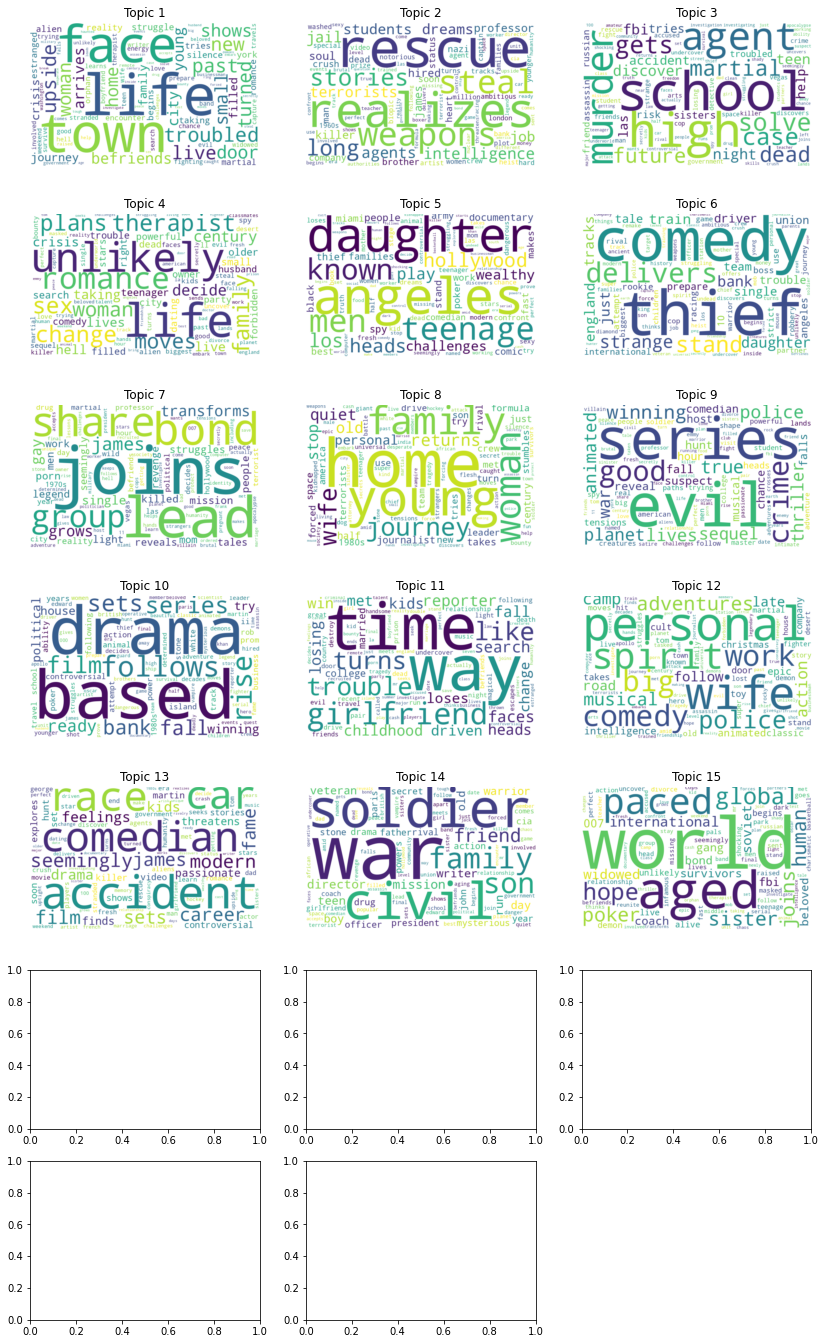

In [221]:
def plot_word_cloud(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True) # sorts betas by descending order
    df = pd.DataFrame(indices[:100].numpy(), columns=['index'])
    words = pd.merge(df, v[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:100] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")

beta = prodLDA.beta()
fig, axs = plt.subplots(7, 3, figsize=(14, 24))
for n in range(beta.shape[0]):
    i, j = divmod(n, 3)
    plot_word_cloud(beta[n], axs[i, j], vocab, n)
axs[-1, -1].axis('off');

plt.show()

**adding topic number and probability of being in topic to netflix db**
- for each movie, need to find largest topic probability based on words in docs corpus array

In [222]:
# betas is a TxW array where T is number of topics, W is number of words
# betas[i, j] gives probability that word j is in topic i
betas = prodLDA.beta()
# for each movie, find maximum of beta values to assign topic
topics = []
topic_probs = []
num_movies = len(eval_df)
for i in range(num_movies):
    words_tensor = docs[i]
    word_indices = ((words_tensor==1).nonzero(as_tuple=True)[0]) # get indices of words used in movie eval_df[i]
    max_probability = 0
    topic = None
    for word_index in word_indices: # find max topic prob given words in movie i from betas object
        max_word_probability = max(betas[:,word_index]).numpy()
        if max_word_probability > max_probability:
            max_probability = max_word_probability
            topic = torch.argmax(betas[:,word_index]).numpy()+1
    topics.append(topic)
    topic_probs.append(max_probability)
eval_df['Topic'] = topics
eval_df['Probability'] = topic_probs
eval_df['Doc'] = range(num_movies)

# reset movieId and userId so that they are consecutive
codes, uniques = pd.factorize(eval_df['movieId'], sort=True)
num_movies = eval_df['movieId'].nunique()
eval_df['movieId'] = codes
print(num_movies)
print(eval_df['title'].nunique())

print(len(eval_df))
eval_df.head()

1119
1058
1119


,index,title,description,movieId,Topic,Probability,Doc
0,27,Grown Ups,Mourning the loss of their beloved junior high...,714,15,0.3585544,0
1,28,Dark Skies,A familys idyllic suburban life shatters when ...,834,8,0.39433476,1
2,41,Jaws,When an insatiable great white shark terrorize...,104,9,0.2931017,2
3,42,Jaws 2,Four years after the last deadly shark attacks...,105,9,0.2931017,3
4,44,Jaws: The Revenge,"After another deadly shark attack, Ellen Brody...",288,10,0.30733582,4


In [223]:
def recommend_by_storyline(title, df): # per jessica's code
    recommended = []
    top10_list = []
    
    title = title.lower()
    df['title'] = df['title'].str.lower()
    topic_num = df[df['title']==title].Topic.values
    if len(topic_num) == 0:
        print(title + " not in database")
        return
    doc_num = df[df['title']==title].Doc.values    
    
    output_df = df[df['Topic']==topic_num[0]].sort_values('Probability', ascending=False).reset_index(drop=True)

    index = output_df[output_df['Doc']==doc_num[0]].index[0]
    
    # return the 10 results with closest probability of belonging to topic `topic_num`
    top10_list += list(output_df.iloc[index-5:index].index)
    top10_list += list(output_df.iloc[index+1:index+6].index)
    
    output_df['title'] = output_df['title'].str.title()
    for each in top10_list:
        recommended.append(output_df.iloc[each].title)
        
    return recommended

In [224]:
recommend_by_storyline("Jaws", eval_df)

['The Square',
 'Miss Sloane',
 'Virunga',
 'Supergirl',
 'Kill The Irishman',
 'Jaws 2',
 'Kill Bill: Vol. 1',
 'The Space Between Us',
 'The Little Prince',
 'Magnolia']

now, we have a way to recommend movies given a movie, now we move to **evaluation** of our model
- **MAP@K**
- **MAR@K**
- **coverage**: percent of items in the traning data the movie is able to recommend on a test set
- **personalization**: dissimilarity (1 - cosine similarity) between user's lists of recommendations

using movielens dataset of user ratings in order to evaluate based on our top 10 movies for our model?
in small movielens db, we have 1119 possible movies

let's say that the movies we recommend to each user are the top 10 in the topic that they have the most
5.0 ratings in. if no 5.0 ratings, ..

relevant links:  
https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093  
http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html

In [225]:
# join with ratings_df on movieId to begin evaluation
users_df = eval_df.merge(ratings_df, on='movieId', how='left')
num_users = users_df['userId'].nunique()

codes, uniques = pd.factorize(users_df['userId'], sort=True)
users_df['userId'] = codes
print(num_users)

users_df

604


,index,title,description,movieId,Topic,Probability,Doc,userId,rating,timestamp
0,27,grown ups,Mourning the loss of their beloved junior high...,714,15,0.3585544,0,27,3.5,1.234571e+09
1,27,grown ups,Mourning the loss of their beloved junior high...,714,15,0.3585544,0,104,4.5,1.448196e+09
2,27,grown ups,Mourning the loss of their beloved junior high...,714,15,0.3585544,0,121,5.0,1.461563e+09
3,27,grown ups,Mourning the loss of their beloved junior high...,714,15,0.3585544,0,169,5.0,8.669045e+08
4,27,grown ups,Mourning the loss of their beloved junior high...,714,15,0.3585544,0,180,4.5,1.064783e+09
...,...,...,...,...,...,...,...,...,...,...
24056,8866,zoom,"Dragged from civilian life, a former superhero...",1018,1,0.369403,1118,83,3.0,8.603988e+08
24057,8866,zoom,"Dragged from civilian life, a former superhero...",1018,1,0.369403,1118,112,3.0,9.803073e+08
24058,8866,zoom,"Dragged from civilian life, a former superhero...",1018,1,0.369403,1118,214,2.0,9.559446e+08
24059,8866,zoom,"Dragged from civilian life, a former superhero...",1018,1,0.369403,1118,290,1.0,9.665962e+08


In [226]:
# for each topic, precompute sorted probabilities
per_topic = [] # list of dfs

for topic in range(1, num_topics+1):
    output_df = eval_df[eval_df['Topic']==topic].sort_values('Probability', ascending=False).reset_index(drop=True)
    per_topic.append(output_df)

In [227]:
# calculate recommendations for each user
"""
as suggested in project proposal, number of recommendations k depends on user
we set k = minimum(number of movies the user has given 5 stars, number of movies the user has given 4 stars)

we calculate recommendation by taking all movies that the user rated 5 stars (or 4 stars if no 5 stars)
then, for each movie, we find the topic it is in by finding the topic that it has the highest probability in
and find the movie in that topic with probability closest to that movie's topic probabiity
"""

# find all 4 and 5 star ratings
user_5_df = users_df[users_df['rating']==5]
user_4_df = users_df[users_df['rating']==4]

# for each user, calculate recommended movies
# recommendations is 2d array where recommendations[i] is a list with first value = userId, 
# subsequent values are k recommended movieIds for the user 
# where k is number of 5 star ratings given by user and if no 5 star ratings, number of 4 star ratings given by user
recommendations = []
for user in range(num_users):
    # find number of 5 ratings
    temp_df = user_5_df[user_5_df['userId']==user]
    temp_df
    # if no 5 ratings, find number of 4 ratings
    if temp_df.empty:
        temp_df = user_4_df[user_4_df['userId']==user]
    # if no 4 ratings, go to next user
    # if temp_df.empty:
    #     continue
    recommendations.append([user])
    # for each movie
    for index, row in temp_df.iterrows():
        topic = row['Topic']
        movieId = row['movieId']
        prob = row['Probability']
        topic_df = per_topic[topic-1]
        # find closest probability in topic to the current movie
        index = topic_df[topic_df['movieId']==movieId].index[0]
        # accounting for out of bound accessing
        if index == 0:
            recommendations[-1].append(row_below['movieId'])
            continue
        if index == len(topic_df)-1:
            recommendations[-1].append(row_above['movieId'])
            continue    
        row_above = topic_df.iloc[index-1]
        row_below = topic_df.iloc[index+1]
        if row_below['Probability'] - prob < row_above['Probability'] - prob:
            recommendations[-1].append(row_below['movieId'])
        else:
            recommendations[-1].append(row_above['movieId'])

print(len(recommendations))


604


In [228]:
# calculate personalization matrix
# https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093
# create num_user x num_movies
num_users = len(recommendations)
personalization = np.zeros((num_users, num_movies))

for row in recommendations:
    user = row[0]
    for movie_ind in row[1:]:
        personalization[user][movie_ind] = 1

cosine_sim = cosine_similarity(personalization, personalization)

# compute average of upper triangle to get cosine similarity
sum = 0
denom = (num_users-1)*(num_users)/2
for i in range(num_users-1):
    for j in range(i+1, num_users):
        sum += cosine_sim[i][j]

similarity = sum/denom
dissimilarity = 1 - similarity
print(dissimilarity)

0.9256013212939652


In [230]:
# calculate MAP @ k 
# http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html

# for each user
map_k = 0
for user in range(num_users):
    l = len(recommendations[user])
    user_actual = user_5_df[user_5_df['userId']==user]['movieId']
    if user_actual.empty:
        user_actual = user_4_df[user_4_df['userId']==user]
    sum = 0
    rec_for_map = []
    for k in range(1, l):
        # top k recommendations and top k actually rated movies for user
        user_rec = recommendations[user][1:k+1]
        user_actual_k = set(user_actual[:k])
        # only add if the kth item was relevant
        if user_rec[-1] in user_actual_k:
            # find intersections 
            user_rec = set(user_rec)
            intersection = list(user_rec & user_actual_k)
            # add precision to sum
            sum += len(intersection)/float(k)
    # divide by m, number of movies
    sum /= float(num_movies)
    map_k += sum

# print final map@k value
map_k /= float(num_users)
print(map_k)

9.559246003069594e-06


In [231]:
# # find topic with highest average movie rating for each user
# user_topic_df = users_df.groupby(by=["userId", "Topic"])['rating'].mean()
# user_topic_df = user_topic_df.reset_index()
# user_topic_df.dropna(inplace=True)
# user_topic_df = user_topic_df.loc[user_topic_df.groupby('userId')['rating'].idxmax()]
# print(user_topic_df.head())

# # find number of movies user has given 5 stars
# user_no_rated_df = users_df[users_df['rating']==5].groupby(by=['userId', 'rating'])['movieId'].count()
# user_no_rated_df = user_no_rated_df.reset_index()
# print(user_no_rated_df.head())
# print(len(user_no_rated_df))

# tester = users_df[users_df['userId']==10]
# print(user_no_rated_df[user_no_rated_df['userId']==10])
# print(user_5_df[user_5_df['userId']==10])
# tester